## German credit data

In [1]:
using CSV;
using DataFrames;
using LinearAlgebra;
using Distributions;
using Images, FileIO;
using RCall;
@rlibrary ggplot2
@rlibrary ggimage
@rlibrary emojifont
@rlibrary viridis
@rlibrary magick

In [2]:
include("../julia/utils.jl");
include("../julia/bayes_logreg.jl");
include("../julia/optimization.jl");
include("../julia/gradients.jl");
include("../julia/generate_recourse.jl");
include("../julia/experiments.jl")

experiment_dynamic (generic function with 1 method)

In [3]:
df = CSV.read("../data/credit.csv", DataFrame);
df[!,:] = convert.(Float64, df[!,:]); # convert to floats

In [4]:
y = df[:,:y];
N = length(y);
X = Matrix(df[:,Not(:y)]);
model = bayes_logreg(X,y);
w = model.μ;

┌ Warning: The closest lower feasible false positive rate to some of the required values (0.0033444816053511705, 0.006688963210702341, 0.010033444816053512, 0.013377926421404682, 0.016722408026755852, 0.020066889632107024, 0.023411371237458192, 0.026755852842809364, 0.030100334448160536, 0.033444816053511704, 0.03678929765886288, 0.04013377926421405, 0.043478260869565216, 0.046822742474916385, 0.05016722408026756, 0.05351170568561873, 0.056856187290969896, 0.06020066889632107, 0.06354515050167224, 0.06688963210702341, 0.07023411371237458, 0.07357859531772576, 0.07692307692307693, 0.0802675585284281, 0.08361204013377926, 0.08695652173913043, 0.0903010033444816, 0.09364548494983277, 0.09698996655518395, 0.10033444816053512, 0.10367892976588629, 0.10702341137123746, 0.11036789297658862, 0.11371237458193979, 0.11705685618729098, 0.12040133779264214, 0.12374581939799331, 0.12709030100334448, 0.13043478260869565, 0.13377926421404682, 0.13712374581939799, 0.14046822742474915, 0.14381270903010

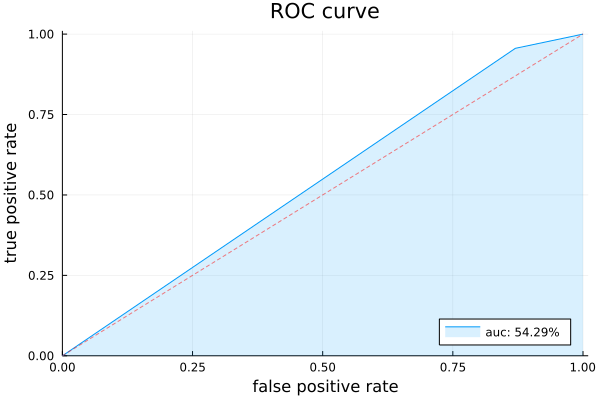

In [5]:
using EvalMetrics
using Plots
y_hat = predict(model,X)
rocplot(y,y_hat)

In [6]:
generators = (wachter = generate_recourse_wachter, schut = generate_recourse_schut);
generator_args = (wachter=(λ=0.01,), schut=(T=1000,δ=0.05));
target = 1;

In [7]:
props = [0.01,0.05,0.1,0.25]
results = DataFrame()
for prop in props
    results_prop = run_experiment(X,y,bayes_logreg,target,generators,generator_args,experiment_dynamic)
    insertcols!(results_prop, :prop => prop)
    results = vcat(results, results_prop)
end

Possible that these results are driven by the following fact:

- classifier is biased towards target class (try random over/undersampling)

In [11]:
dt_plot = groupby(results, [:period, :generator, :prop]) |>
    gdf -> combine(gdf, :validity .=> [mean, std] .=> [:mean, :std])
dt_plot[!,:ymin] = dt_plot[!,:mean] - dt_plot[!,:std]
dt_plot[!,:ymax] = dt_plot[!,:mean] + dt_plot[!,:std]
ggplot(data=dt_plot, aes(x=:period, y=:mean, colour=:generator)) +
    geom_line() + 
    geom_errorbar(aes(ymin=:ymin, ymax=:ymax), width=.2) + 
    geom_point() +
    facet_wrap(R".~prop") +
    theme_bw() |>
    p -> ggsave("www/german_dynamic_validity.png", plot = p);
load("www/german_dynamic_validity.png")

┌ Warning: RCall.jl: Saving 7 x 7 in image
└ @ RCall /Users/FA31DU/.julia/packages/RCall/iMDW2/src/io.jl:160


LoadError: UndefVarError: load not defined

Interesting to see that there are some clear trends in the cost of recourse over time:

- what could be the reason for these dynamics?

In [ ]:
dt_plot = groupby(results, [:period, :generator, :prop]) |>
    gdf -> combine(gdf, :cost .=> [mean, std] .=> [:mean, :std])
dt_plot[!,:ymin] = dt_plot[!,:mean] - dt_plot[!,:std]
dt_plot[!,:ymax] = dt_plot[!,:mean] + dt_plot[!,:std]
ggplot(data=dt_plot, aes(x=:period, y=:mean, colour=:generator)) +
    geom_line() + 
    geom_errorbar(aes(ymin=:ymin, ymax=:ymax), width=.2) + 
    geom_point() +
    facet_wrap(R".~prop") +
    theme_bw() |>
    p -> ggsave("www/german_dynamic_cost.png", plot = p);
load("www/german_dynamic_cost.png")

### Adjusting for imbalance

In [ ]:
using MLDataUtils
X_train, y_train = oversample((transpose(X),y))
X_train = transpose(X_train);
model = bayes_logreg(X_train,y_train);

In [ ]:
y_hat = predict(model,X)
rocplot(y,y_hat)